# Spam & Fake News Detection

## Overview
A machine learning project to classify text as spam (emails/SMS) or fake news using NLP techniques.

## Features
- Detects spam messages and fake news articles
- Interactive Gradio interface for real-time testing
- Compares multiple ML algorithms
- Visualizes results and saves models

## Tech Stack
- **Python**
- **scikit-learn** (Naive Bayes, Random Forest, Logistic Regression)
- **pandas, numpy**
- **nltk**
- **matplotlib, seaborn**
- **Gradio**
- **joblib**

## What I've Done
- Preprocessed and vectorized text data
- Trained and evaluated ML models
- Built an interactive demo with Gradio
- Visualized and saved model results


In [1]:
## Step 1: Install Required Libraries
# Install necessary libraries for text classification and UI
!pip install pandas scikit-learn gradio matplotlib seaborn wordcloud nltk


In [2]:
## Step 2: Import Libraries and Download NLTK Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import gradio as gr
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
## Step 3: Create Sample Datasets
# Create sample spam detection dataset
spam_data = {
    'text': [
        'Congratulations! You have won $1000. Click here to claim your prize now!',
        'URGENT: Your account will be suspended. Verify your details immediately.',
        'Get rich quick! Make thousands from home with this amazing opportunity!',
        'Free iPhone! Limited time offer. Act now!',
        'Hi, are we still meeting for lunch tomorrow?',
        'Please review the attached document for our project.',
        'Thanks for the meeting today. Looking forward to our collaboration.',
        'The weather forecast shows rain this weekend.',
        'Your package has been delivered successfully.',
        'Meeting rescheduled to 3 PM tomorrow.',
        'WINNER! You are selected for a cash prize of $5000!',
        'Click this link to update your banking information urgently!',
        'Amazing weight loss pills! Lose 30 pounds in 30 days!',
        'Your prescription is ready for pickup.',
        'Conference call starts in 10 minutes.',
        'Thank you for your payment. Your order is being processed.',
        'Limited time offer! Buy one get one free!',
        'Your appointment has been confirmed for Monday.',
        'Emergency! Your computer is infected. Download our antivirus now!',
        'Happy birthday! Hope you have a wonderful day!'
    ],
    'label': [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]  # 1 = spam, 0 = not spam
}

# Create sample fake news dataset
news_data = {
    'text': [
        'Scientists discover cure for all cancers in breakthrough study.',
        'Local school wins national science competition for third consecutive year.',
        'Government announces new tax benefits for small businesses.',
        'Aliens confirmed to have landed in major city yesterday.',
        'Stock market reaches all-time high amid economic recovery.',
        'Celebrity spotted at local coffee shop, confirms new movie project.',
        'Weather service predicts mild winter conditions this year.',
        'Miracle drug makes people live 200 years, doctors hate this trick.',
        'New study shows drinking water improves health outcomes.',
        'City council approves budget for new public library construction.',
        'Breaking: Time travel machine invented by teenager in garage.',
        'Local restaurant receives five-star rating from food critics.',
        'University research team develops new sustainable energy solution.',
        'Dinosaurs found alive in remote jungle, photos prove existence.',
        'Technology company announces quarterly earnings above expectations.',
        'Community volunteers clean up local park in weekend initiative.',
        'Magic pills eliminate need for exercise, fitness trainers worried.',
        'Museum opens new exhibition featuring historical artifacts.',
        'Government officials deny any knowledge of secret alien meetings.',
        'Sports team wins championship in thrilling final match.'
    ],
    'label': [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]  # 1 = fake, 0 = real
}

# Convert to DataFrames
spam_df = pd.DataFrame(spam_data)
news_df = pd.DataFrame(news_data)

print("Spam Detection Dataset:")
print(spam_df.head())
print(f"\nDataset shape: {spam_df.shape}")
print(f"Spam distribution:\n{spam_df['label'].value_counts()}")

print("\n" + "="*50)
print("Fake News Detection Dataset:")
print(news_df.head())
print(f"\nDataset shape: {news_df.shape}")
print(f"News distribution:\n{news_df['label'].value_counts()}")


Spam Detection Dataset:
                                                text  label
0  Congratulations! You have won $1000. Click her...      1
1  URGENT: Your account will be suspended. Verify...      1
2  Get rich quick! Make thousands from home with ...      1
3          Free iPhone! Limited time offer. Act now!      1
4       Hi, are we still meeting for lunch tomorrow?      0

Dataset shape: (20, 2)
Spam distribution:
label
0    11
1     9
Name: count, dtype: int64

Fake News Detection Dataset:
                                                text  label
0  Scientists discover cure for all cancers in br...      1
1  Local school wins national science competition...      0
2  Government announces new tax benefits for smal...      0
3  Aliens confirmed to have landed in major city ...      1
4  Stock market reaches all-time high amid econom...      0

Dataset shape: (20, 2)
News distribution:
label
0    13
1     7
Name: count, dtype: int64


In [4]:
## Step 4: Data Preprocessing Functions
# Text preprocessing function
def preprocess_text(text):
    """
    Preprocess text by removing special characters, converting to lowercase,
    and removing stopwords.
    """
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words])

    return text

# Apply preprocessing to both datasets
spam_df['cleaned_text'] = spam_df['text'].apply(preprocess_text)
news_df['cleaned_text'] = news_df['text'].apply(preprocess_text)

print("Sample preprocessed text:")
print("Original:", spam_df['text'].iloc[0])
print("Cleaned:", spam_df['cleaned_text'].iloc[0])


Sample preprocessed text:
Original: Congratulations! You have won $1000. Click here to claim your prize now!
Cleaned: congratulations click claim prize


In [5]:
## Step 5: Feature Extraction and Model Training
# Create and train spam detection model
def create_spam_model():
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        spam_df['cleaned_text'], spam_df['label'],
        test_size=0.3, random_state=42
    )

    # Create pipeline with TF-IDF and Naive Bayes
    spam_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
        ('classifier', MultinomialNB())
    ])

    # Train the model
    spam_pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = spam_pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)

    print("=== SPAM DETECTION MODEL ===")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Spam', 'Spam']))

    return spam_pipeline

# Create and train fake news detection model
def create_news_model():
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        news_df['cleaned_text'], news_df['label'],
        test_size=0.3, random_state=42
    )

    # Create pipeline with TF-IDF and Random Forest
    news_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    # Train the model
    news_pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = news_pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)

    print("=== FAKE NEWS DETECTION MODEL ===")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Real News', 'Fake News']))

    return news_pipeline

# Train both models
spam_model = create_spam_model()
news_model = create_news_model()


=== SPAM DETECTION MODEL ===
Accuracy: 0.8333

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.80      1.00      0.89         4
        Spam       1.00      0.50      0.67         2

    accuracy                           0.83         6
   macro avg       0.90      0.75      0.78         6
weighted avg       0.87      0.83      0.81         6

=== FAKE NEWS DETECTION MODEL ===
Accuracy: 0.8333

Classification Report:
              precision    recall  f1-score   support

   Real News       0.83      1.00      0.91         5
   Fake News       0.00      0.00      0.00         1

    accuracy                           0.83         6
   macro avg       0.42      0.50      0.45         6
weighted avg       0.69      0.83      0.76         6



In [6]:
## Step 6: Model Comparison with Different Algorithms
# Compare different algorithms for spam detection
def compare_spam_algorithms():
    X_train, X_test, y_train, y_test = train_test_split(
        spam_df['cleaned_text'], spam_df['label'],
        test_size=0.3, random_state=42
    )

    # Vectorize the text
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Different algorithms to compare
    algorithms = {
        'Naive Bayes': MultinomialNB(),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }

    results = []

    for name, algorithm in algorithms.items():
        # Train the model
        algorithm.fit(X_train_tfidf, y_train)

        # Make predictions
        y_pred = algorithm.predict(X_test_tfidf)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        results.append({'Algorithm': name, 'Accuracy': accuracy})

        print(f"{name} - Accuracy: {accuracy:.4f}")

    return pd.DataFrame(results)

# Compare algorithms
comparison_results = compare_spam_algorithms()
print("\nAlgorithm Comparison Results:")
print(comparison_results)


Naive Bayes - Accuracy: 0.8333
Random Forest - Accuracy: 0.6667
Logistic Regression - Accuracy: 0.8333

Algorithm Comparison Results:
             Algorithm  Accuracy
0          Naive Bayes  0.833333
1        Random Forest  0.666667
2  Logistic Regression  0.833333


In [9]:
## Step 7: Create Interactive Gradio Interface

# Prediction functions for Gradio interface
def predict_spam(text):
    """Predict if text is spam or not"""
    if not text.strip():
        return "Please enter some text to analyze."

    processed_text = preprocess_text(text)
    prediction = spam_model.predict([processed_text])[0]
    probability = spam_model.predict_proba([processed_text])[0]

    if prediction == 1:
        result = f"🚨 SPAM DETECTED!\nConfidence: {probability[1]:.2%}"
    else:
        result = f"✅ Legitimate Message\nConfidence: {probability[0]:.2%}"

    return result

def predict_fake_news(text):
    """Predict if news is fake or real"""
    if not text.strip():
        return "Please enter some text to analyze."

    processed_text = preprocess_text(text)
    prediction = news_model.predict([processed_text])[0]
    probability = news_model.predict_proba([processed_text])[0]

    if prediction == 1:
        result = f"⚠️ FAKE NEWS DETECTED!\nConfidence: {probability[1]:.2%}"
    else:
        result = f"✅ Real News\nConfidence: {probability[0]:.2%}"

    return result

# Create Gradio interface
def create_gradio_interface():
    """Create interactive Gradio interface for testing both models"""

    with gr.Blocks(title="Spam & Fake News Detector", theme=gr.themes.Soft()) as demo:
        gr.Markdown("# 🛡️ Spam & Fake News Detection System")
        gr.Markdown("Enter text below to check if it's spam/legitimate or fake/real news using AI classification.")

        with gr.Tab("Spam Detection"):
            gr.Markdown("### 📧 Email/SMS Spam Detector")
            gr.Markdown("Enter an email or SMS message to check if it's spam:")

            spam_input = gr.Textbox(
                label="Enter Email/SMS Text",
                placeholder="Type your message here...",
                lines=3
            )
            spam_output = gr.Textbox(label="Prediction Result", lines=2)
            spam_button = gr.Button("Check for Spam", variant="primary")

            spam_button.click(
                fn=predict_spam,
                inputs=spam_input,
                outputs=spam_output
            )

            gr.Markdown("#### Example Spam Messages to Test:")
            gr.Markdown("- *Congratulations! You have won $1000. Click here to claim your prize!*")
            gr.Markdown("- *URGENT: Your account will be suspended. Verify details immediately.*")

        with gr.Tab("Fake News Detection"):
            gr.Markdown("### 📰 Fake News Detector")
            gr.Markdown("Enter a news article or headline to check its authenticity:")

            news_input = gr.Textbox(
                label="Enter News Text",
                placeholder="Type news article or headline here...",
                lines=4
            )
            news_output = gr.Textbox(label="Prediction Result", lines=2)
            news_button = gr.Button("Check News Authenticity", variant="primary")

            news_button.click(
                fn=predict_fake_news,
                inputs=news_input,
                outputs=news_output
            )

            gr.Markdown("#### Example Headlines to Test:")
            gr.Markdown("- *Scientists discover cure for all cancers in breakthrough study.*")
            gr.Markdown("- *Local school wins national science competition for third year.*")

    return demo

# Launch the Gradio interface
print("Creating interactive interface...")
demo = create_gradio_interface()
demo.launch(share=True, debug=True)


Creating interactive interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://036a2e3c14fcbcd212.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://036a2e3c14fcbcd212.gradio.live


In [8]:
# Test the models with multiple examples
def batch_testing():
    """Test both models with predefined examples"""

    # Test cases for spam detection
    spam_test_cases = [
        "Hi, are we still meeting for lunch tomorrow?",
        "WINNER! You have been selected for a $5000 cash prize!",
        "Your package has been delivered successfully.",
        "Click this link to update your banking information URGENTLY!"
    ]

    # Test cases for fake news detection
    news_test_cases = [
        "Local library announces extended weekend hours for students.",
        "Aliens confirmed to have landed in New York City yesterday.",
        "Stock market reaches record high amid economic recovery.",
        "Scientists invent pill that makes people live 300 years."
    ]

    print("=== SPAM DETECTION BATCH TESTING ===")
    for i, text in enumerate(spam_test_cases, 1):
        result = predict_spam(text)
        print(f"\nTest {i}: {text[:50]}...")
        print(f"Result: {result}")

    print("\n" + "="*60)
    print("=== FAKE NEWS DETECTION BATCH TESTING ===")
    for i, text in enumerate(news_test_cases, 1):
        result = predict_fake_news(text)
        print(f"\nTest {i}: {text[:50]}...")
        print(f"Result: {result}")

# Run batch testing
batch_testing()


=== SPAM DETECTION BATCH TESTING ===

Test 1: Hi, are we still meeting for lunch tomorrow?...
Result: ✅ Legitimate Message
Confidence: 76.45%

Test 2: WINNER! You have been selected for a $5000 cash pr...
Result: 🚨 SPAM DETECTED!
Confidence: 67.96%

Test 3: Your package has been delivered successfully....
Result: ✅ Legitimate Message
Confidence: 50.00%

Test 4: Click this link to update your banking information...
Result: 🚨 SPAM DETECTED!
Confidence: 68.27%

=== FAKE NEWS DETECTION BATCH TESTING ===

Test 1: Local library announces extended weekend hours for...
Result: ✅ Real News
Confidence: 76.00%

Test 2: Aliens confirmed to have landed in New York City y...
Result: ⚠️ FAKE NEWS DETECTED!
Confidence: 51.00%

Test 3: Stock market reaches record high amid economic rec...
Result: ✅ Real News
Confidence: 89.00%

Test 4: Scientists invent pill that makes people live 300 ...
Result: ✅ Real News
Confidence: 56.00%


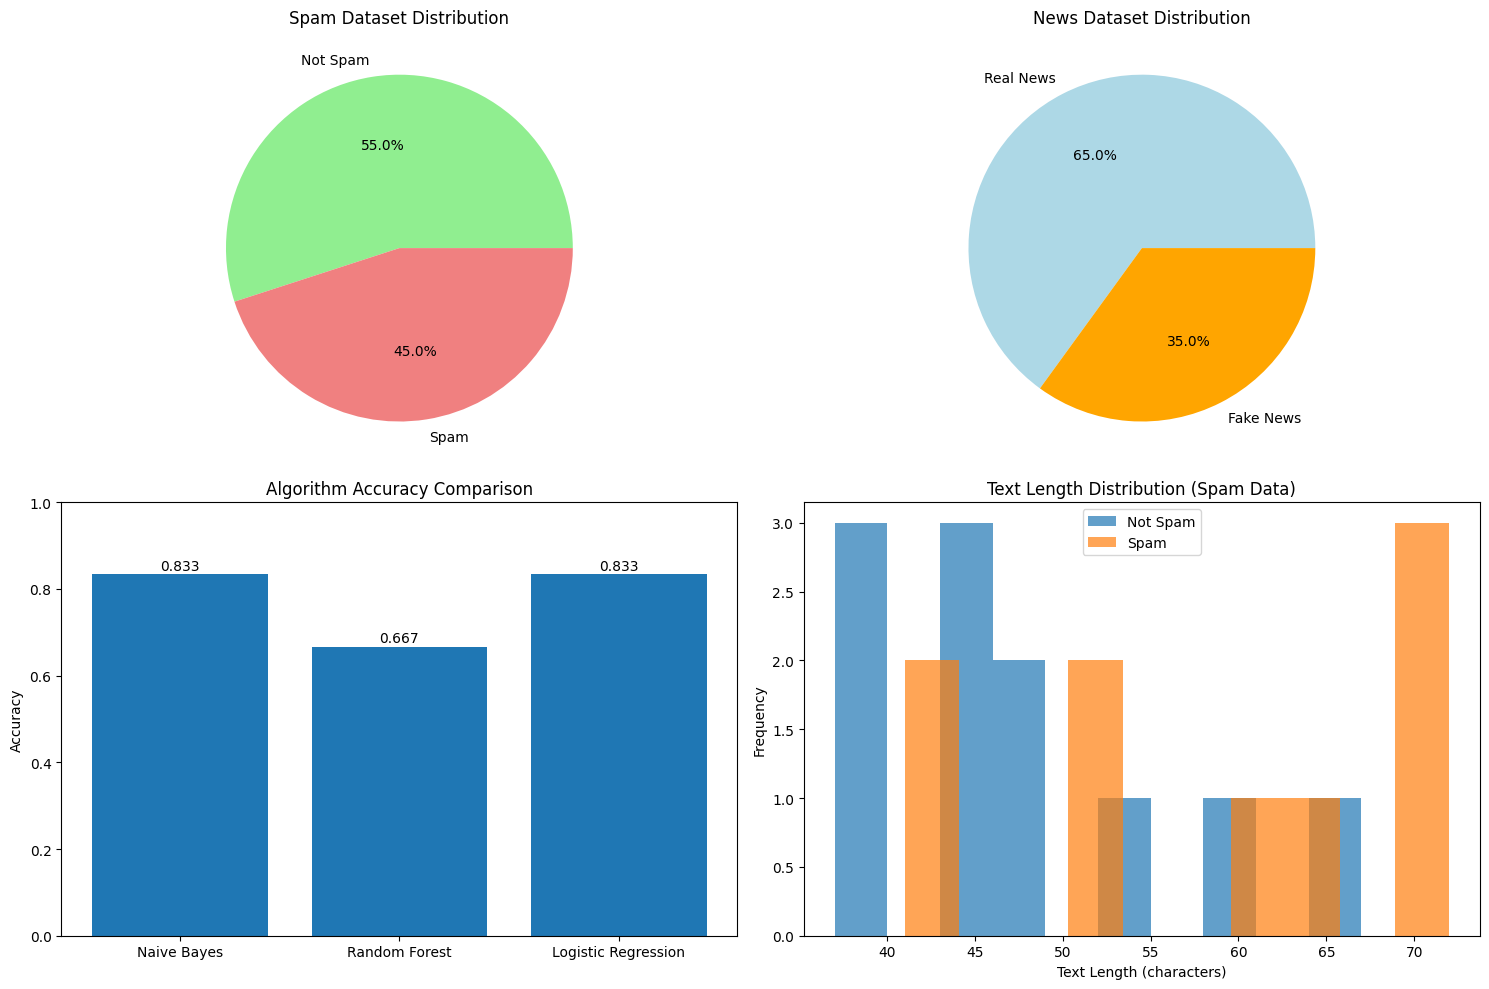

In [10]:
# Visualize model performance
def visualize_performance():
    """Create visualizations for model performance analysis"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Spam dataset distribution
    spam_counts = spam_df['label'].value_counts()
    axes[0,0].pie(spam_counts.values, labels=['Not Spam', 'Spam'], autopct='%1.1f%%',
                  colors=['lightgreen', 'lightcoral'])
    axes[0,0].set_title('Spam Dataset Distribution')

    # News dataset distribution
    news_counts = news_df['label'].value_counts()
    axes[0,1].pie(news_counts.values, labels=['Real News', 'Fake News'], autopct='%1.1f%%',
                  colors=['lightblue', 'orange'])
    axes[0,1].set_title('News Dataset Distribution')

    # Algorithm comparison
    if 'comparison_results' in globals():
        axes[1,0].bar(comparison_results['Algorithm'], comparison_results['Accuracy'])
        axes[1,0].set_title('Algorithm Accuracy Comparison')
        axes[1,0].set_ylabel('Accuracy')
        axes[1,0].set_ylim(0, 1)

        # Add accuracy values on bars
        for i, v in enumerate(comparison_results['Accuracy']):
            axes[1,0].text(i, v + 0.01, f'{v:.3f}', ha='center')

    # Text length analysis
    spam_df['text_length'] = spam_df['text'].str.len()
    news_df['text_length'] = news_df['text'].str.len()

    axes[1,1].hist(spam_df[spam_df['label']==0]['text_length'], alpha=0.7, label='Not Spam', bins=10)
    axes[1,1].hist(spam_df[spam_df['label']==1]['text_length'], alpha=0.7, label='Spam', bins=10)
    axes[1,1].set_title('Text Length Distribution (Spam Data)')
    axes[1,1].set_xlabel('Text Length (characters)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

# Generate visualizations
visualize_performance()


In [11]:
# Save trained models for future use
import joblib

def save_models():
    """Save trained models to disk"""
    joblib.dump(spam_model, 'spam_detection_model.pkl')
    joblib.dump(news_model, 'fake_news_detection_model.pkl')
    print("✅ Models saved successfully!")
    print("- spam_detection_model.pkl")
    print("- fake_news_detection_model.pkl")

def load_models():
    """Load saved models from disk"""
    try:
        loaded_spam_model = joblib.load('spam_detection_model.pkl')
        loaded_news_model = joblib.load('fake_news_detection_model.pkl')
        print("✅ Models loaded successfully!")
        return loaded_spam_model, loaded_news_model
    except FileNotFoundError:
        print("❌ Model files not found. Please train and save models first.")
        return None, None

# Save the trained models
save_models()

# Test loading models
loaded_spam_model, loaded_news_model = load_models()


✅ Models saved successfully!
- spam_detection_model.pkl
- fake_news_detection_model.pkl
✅ Models loaded successfully!
